In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%pylab inline
pylab.rcParams.update({'font.size': 12})
pylab.rcParams.update({'font.family': 'sans serif'})
pylab.rcParams.update({'mathtext.default':'regular'})
pylab.rcParams.update({'mathtext.fontset':'stixsans'})
pylab.rcParams.update({'axes.linewidth': 1.5})
pylab.rcParams.update({'xtick.direction':'in'})
pylab.rcParams.update({'xtick.major.size': 5})
pylab.rcParams.update({'xtick.major.width': 1.25 })
pylab.rcParams.update({'xtick.minor.size': 2.5})
pylab.rcParams.update({'xtick.minor.width': 1.25 })
pylab.rcParams.update({'ytick.direction':'in'})
pylab.rcParams.update({'ytick.major.size': 5})
pylab.rcParams.update({'ytick.major.width': 1.25 })
pylab.rcParams.update({'ytick.minor.size': 2.5})
pylab.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [4]:
class AccretionIntegrator:
    # conversion factors to get CGS units into Cholla units
    MP = 1.6726E-24;  # proton mass in grams
    KB = 1.380658e-16; # Boltzmann constant
    LENGTH_UNIT = 3.08567758e21; # kpc in cm
    TINY_NUMBER = 1.0e-20;
    MASS_UNIT = 1.98855e33; # solar mass in grams
    TIME_UNIT = 3.15569e10; # kyr in s
    DENSITY_UNIT = (MASS_UNIT/(LENGTH_UNIT*LENGTH_UNIT*LENGTH_UNIT)); 
    VELOCITY_UNIT = (LENGTH_UNIT/TIME_UNIT);
    PRESSURE_UNIT = (DENSITY_UNIT*VELOCITY_UNIT*VELOCITY_UNIT);
    
    # solar abundances (percentage of total mass)
    # O, C, N, Si, Mg, Ne, Fe, S
    metals = np.array([0.0097, 0.0040, 0.00096, 0.00099, 0.00076, 0.00058, 0.0014, 0.00040]);
    metallicity = np.sum(metals)
    
    def __init__(self, T, n, dt):
        self.T = T
        self.n = n
        self.dt = dt
        self._d0_gas, self._d0_metal, self._d0_dust = self.calc_init_density()
        self.d_gas, self.d_metal, self.d_dust = self.calc_init_density()
        self.tau_g = self.calc_tau_g()

    def calc_tau_g(self):
        tau_g_ref = 0.2e-6 * self.TIME_UNIT; # 0.2 Gyr
        d_ref = self.MP * self.LENGTH_UNIT ** 3 / self.MASS_UNIT # 1 H atom per cubic centimer
        T_ref = 20.0;

        tau_g = tau_g_ref * (d_ref/(self._d0_gas+self._d0_dust)) * (T_ref/self.T) ** (1/2);

        return tau_g
    
    def calc_init_density(self):
        d0_gas = self.MP * self.n * self.LENGTH_UNIT ** 3 / self.MASS_UNIT
        d0_metal = self.metallicity * d0_gas
        # assume 1% dust to gas fraction
        d0_dust = d0_gas / 100
        
        return d0_gas, d0_metal, d0_dust

    def calc_dd_dt(self):
        dd_dt = (1 - self.d_dust/self.d_metal)*(self.d_dust/self.tau_g)
        
        return dd_dt
    
    def calc_d_dust(self):
        dd_dt = self.calc_dd_dt()
        d_dust_i = self.d_dust + self.dt * dd_dt
        
        return d_dust_i
    
    def update_densities(self):
        dd_dt = self.calc_dd_dt()
        self.d_dust += self.dt * dd_dt
        self.d_metal -= self.dt * dd_dt
    
    def get_info(self):
        print("Gas temperature: {:.1E} K".format(self.T))
        print("Gas initial density: {:.5E} M_sun/kpc^3".format(self._d0_gas))
        print("Growth timescale: {:.5E} kyr".format(self.tau_g))
        print("Time-step: {} yr".format(self.dt))
        print("------------------------------------------")

In [6]:
def evolve_solutions(h, n, T_arr, T_colors):
    t_arr = np.arange(0, 1e7, h)
    
    d_dust = np.zeros(shape=(len(T_arr), len(t_arr)))
    d_metal = np.zeros(shape=(len(T_arr), len(t_arr)))

    integrator = None
    
    def time_refine(integrator):
        d_dust_i = integrator.calc_d_dust()
        dd_dt = integrator.calc_dd_dt()
        dt = integrator.dt
        dd = dd_dt * dt
        while dd/d_dust_i > 0.01:
            dt_sub = 0.01 * d_dust_i / dd_dt

            integrator.d_dust += dt_sub * dd_dt
            integrator.d_metal -= dt_sub * dd_dt
            integrator.dt -= dt_sub
            dt = integrator.dt
            dd_dt = integrator.calc_dd_dt()
            dd = dt * dd_dt

    for j, T in enumerate(T_arr):
        integrator = AccretionIntegrator(T, n, h)
        integrator.get_info()
        # set initial densities
        d_dust[j][0] = integrator._d0_dust
        d_metal[j][0] = integrator._d0_metal

        for i, t_i in enumerate(t_arr):
            if (i+1) < len(t_arr):
                d_dust_i = integrator.calc_d_dust()
                dd_dt = integrator.calc_dd_dt()
                dd = integrator.dt * dd_dt
                
                # if rate of dust growth is changing too rapidly
                if dd/d_dust_i > 0.01:
                    # shorten time-step
                    time_refine(integrator)
                    integrator.dt = h
                    d_dust[j][i+1] = integrator.d_dust
                    d_metal[j][i+1] = integrator.d_metal
                    continue

                integrator.update_densities()
                d_dust[j][i+1] = integrator.d_dust
                d_metal[j][i+1] = integrator.d_metal

    return d_dust, d_metal

In [7]:
T_arr = [10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8]
T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

h = 1
n = 1e-2

dd, dm = evolve_solutions(h, n, T_arr, T_colors)

Gas temperature: 1.0E+01 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.83727E+05 kyr
Time-step: 1 yr
------------------------------------------


KeyboardInterrupt: 

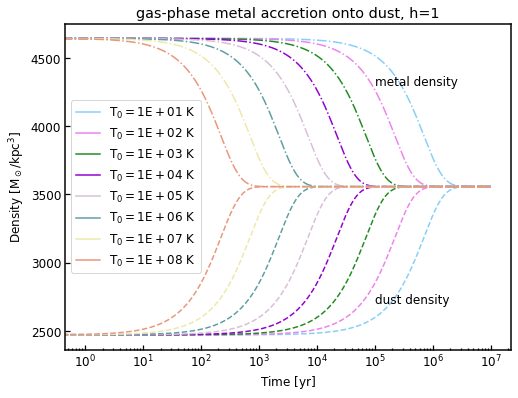

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for j, T in enumerate(T_arr):
    ax.semilogx(np.arange(0, 1e7, h), dd[j], linestyle="--", color=T_colors[j])
    ax.semilogx(np.arange(0, 1e7, h), dm[j], linestyle="-.", color=T_colors[j])
    ax.semilogx(np.ones(5), acc_integrator.d_dust * np.ones(5), linestyle="-", color=T_colors[j], label=f"$T_0={T:.0E}~K$")
ax.annotate("dust density", (0.99999999e5, 2700))
ax.annotate("metal density", (0.9999999e5, 4300))
ax.set_xlabel("Time$~[yr]$")
ax.set_ylabel(r"Density$~[M_\odot/kpc^3]$")
ax.legend()
ax.set_title(f"gas-phase metal accretion onto dust, h={h}")
plt.savefig("/Users/helenarichie/GitHub/helenarichie.github.io/assets/img/posts/accretion_numerical.png", facecolor="white")

In [8]:
T_arr = [10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8]
T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

h = 100
n = 1e-2

dd, dm = evolve_solutions(h, n, T_arr, T_colors)

h = 10
n = 1e-2

dd10, dm10 = evolve_solutions(h, n, T_arr, T_colors)

Gas temperature: 1.0E+01 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.83727E+05 kyr
Time-step: 100 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.79459E+05 kyr
Time-step: 100 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.83727E+04 kyr
Time-step: 100 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.79459E+04 kyr
Time-step: 100 yr
------------------------------------------
Gas temperature: 1.0E+05 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.83727E+03 kyr
Time-step: 100 yr
------------------------------------------
Gas temperature: 1.0E+06 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.79459E+03 kyr
Time-step: 100 yr
-----------------------------------------

Text(0.5, 1.0, 'gas-phase metal accretion onto dust')

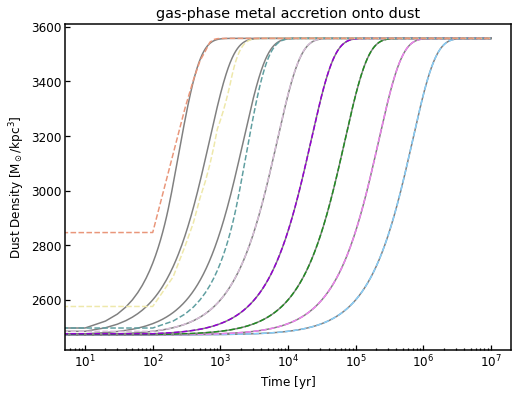

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for j, T in enumerate(T_arr):
    ax.semilogx(np.arange(0, 1e7, 100), dd[j], linestyle="--", color=T_colors[j], label=f"$T_0={T:.0E}~K$")
    #ax.semilogx(np.arange(0, 1e7, 100), dm[j], linestyle="-", color=T_colors[j], label=f"$T_0={T:.0E}~K$")
    #ax.semilogx(np.arange(0, 1e7, 10), dm10[j], linestyle="-", color="grey", label=f"$T_0={T:.0E}~K$", zorder=0)
    ax.semilogx(np.arange(0, 1e7, 10), dd10[j], linestyle="-", color="grey", label=f"$T_0={T:.0E}~K$", zorder=0)
ax.set_xlabel("Time$~[yr]$")
ax.set_ylabel(r"Dust Density$~[M_\odot/kpc^3]$")
#ax.legend()
ax.set_title(f"gas-phase metal accretion onto dust")